In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, RocCurveDisplay

from clulib import parse_data, data_path

In [2]:
energy = 2000
pidata, _, _ = parse_data('pi0', energy, data_path())
gadata, _, _ = parse_data('gamma', energy, data_path())
print(pidata.shape, gadata.shape)

(74627, 28) (96124, 28)


In [3]:
from sklearn.model_selection import train_test_split

## Preprocess data

### Data format

Each cluster is represented by 28 numbers:
 * Flattened 5x5 energy depositions in crystals around the cluster center. The cluster center is defined as clusted with maximal energy deposition
 * Sum of energy deposition beyond the inner 5x5 area
 * z and phi index of the center cluster (not used!)
 
### Data preprocessing
 * Last two values are dropped
 * Other values are normalized so that sum of values equal unity

In [4]:
def preprocess_data(data):
    X = data[:, :-2]
    sums = X.sum(axis=1)
    return X / sums.reshape(-1, 1), sums

In [5]:
def make_data(pidata, gadata):
    pidata0, epi = preprocess_data(pidata)
    gadata0, ega = preprocess_data(gadata)
    print(pidata0.shape)
    print(gadata0.shape)
    X = np.vstack((pidata0, gadata0))
    y = np.concatenate((
        np.zeros(pidata0.shape[0], dtype=int),
        np.ones(gadata0.shape[0], dtype=int)
    ))
    return train_test_split(X, y, test_size=0.2, random_state=47)

In [6]:
X_train, X_test, y_train, y_test = make_data(pidata, gadata)
X_train.shape

(74627, 26)
(96124, 26)


(136600, 26)

# Baseline: linear regressor

Train linear regressor

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.7304143964334253

In [9]:
linear_predict = reg.predict(X_test)

In [10]:
roc_auc_score(y_test, linear_predict)

0.9787332389456617

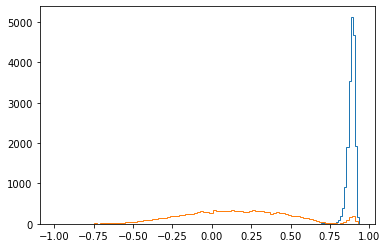

In [11]:
plt.hist(linear_predict[y_test==1], bins=100, histtype='step')
plt.hist(linear_predict[y_test==0], bins=100, histtype='step');

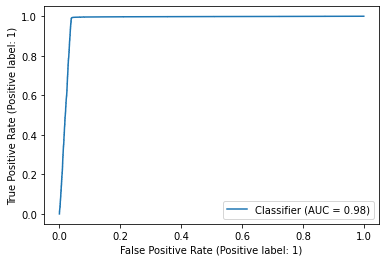

In [12]:
RocCurveDisplay.from_predictions(y_test, linear_predict);

## 1st classifier: neural net

Train neural net classifier with one hidden layer of `100` neurons with 300 epochs

In [13]:
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

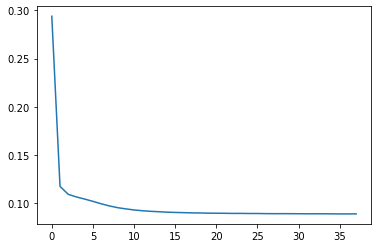

In [14]:
plt.plot(clf.loss_curve_)

In [15]:
clf.score(X_train, y_train)

0.9800219619326501

In [16]:
clf.score(X_test, y_test)

0.9806155017422623

In [17]:
prob = clf.predict_proba(X_test)
prob[0]

array([9.99988829e-01, 1.11705030e-05])

In [18]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.9798908082145276

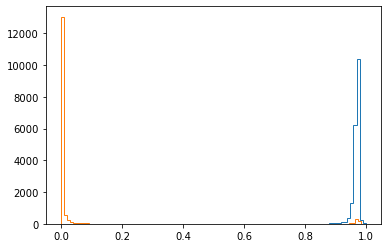

In [19]:
plt.hist(prob[y_test==1][:, 1], bins=100, histtype='step')
plt.hist(prob[y_test==0][:, 1], bins=100, histtype='step');

In [20]:
prob_train = clf.predict_proba(X_train)

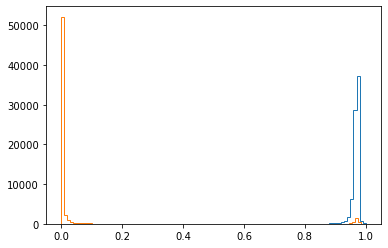

In [21]:
plt.hist(prob_train[y_train==1][:, 1], bins=100, histtype='step')
plt.hist(prob_train[y_train==0][:, 1], bins=100, histtype='step');

In [22]:
clf2 = MLPClassifier(
    random_state=1,
    hidden_layer_sizes=(50, 25),
    max_iter=300).fit(X_train, y_train)

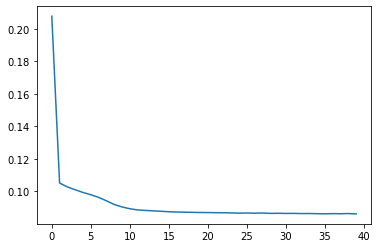

In [23]:
plt.plot(clf2.loss_curve_)

In [24]:
roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1])

0.9809999389718659

In [25]:
prob2 = clf2.predict_proba(X_test)[:, 1]

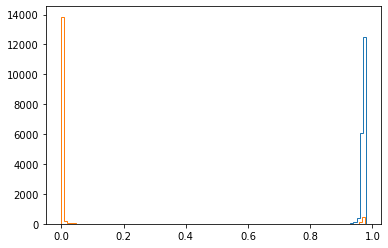

In [26]:
plt.hist(prob2[y_test==1], bins=100, histtype='step')
plt.hist(prob2[y_test==0], bins=100, histtype='step');

# 2nd classifier: Gradient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

In [28]:
gbc = GradientBoostingClassifier(random_state=9).fit(X_train, y_train)

In [29]:
roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])

0.9805712924675093

In [30]:
gbc_prob = gbc.predict_proba(X_test)[:, 1]

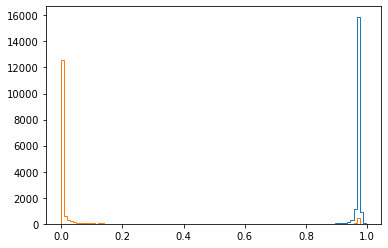

In [31]:
plt.hist(gbc_prob[y_test==1], bins=100, histtype='step')
plt.hist(gbc_prob[y_test==0], bins=100, histtype='step');

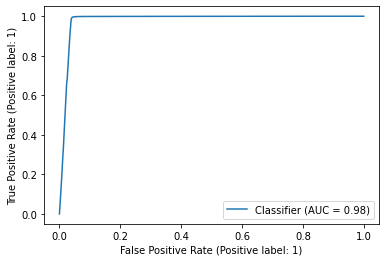

In [32]:
RocCurveDisplay.from_predictions(y_test, gbc_prob)

# 3rd classifies: XGBoost

In [33]:
import xgboost as xgb

In [34]:
param = {'max_depth':2, 'eta':1, 'objective':'binary:logistic'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [35]:
num_round = 20
bst = xgb.train(param, dtrain, num_round)

[15:31:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [36]:
preds = bst.predict(dtest)

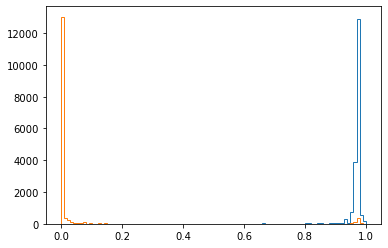

In [37]:
plt.hist(preds[y_test==1], bins=100, histtype='step')
plt.hist(preds[y_test==0], bins=100, histtype='step');

In [38]:
roc_auc_score(y_test, preds)

0.980395675422514

# Examples

In [44]:
misses = np.nonzero((preds > 0.99) & (y_test==0))[0]
misses.size

12

In [40]:
from clulib import draw_cluster_local

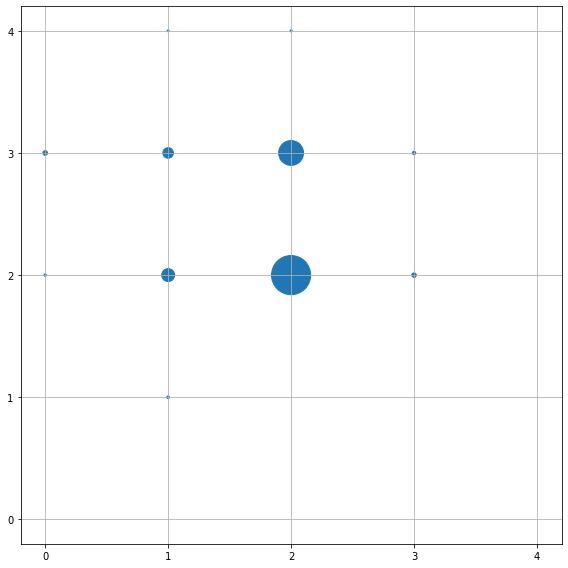

In [45]:
draw_cluster_local(X_test[misses[0]])

In [46]:
confident_pi0 = np.nonzero((preds < 0.01) & (y_test==0))[0]
confident_pi0.size

13034

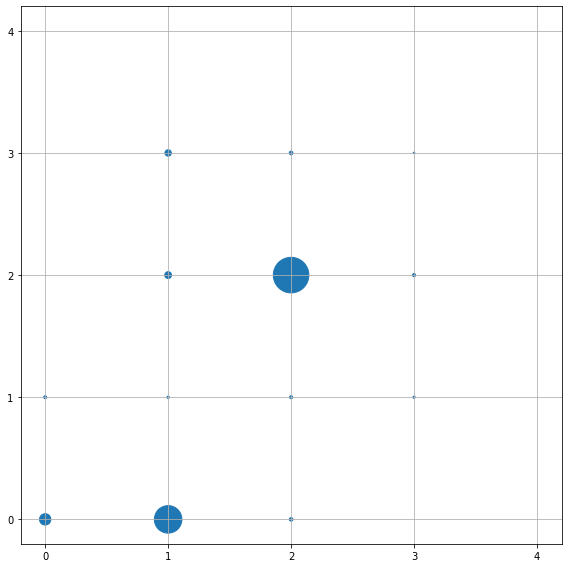

In [47]:
draw_cluster_local(X_test[confident_pi0[0]])

In [48]:
confident_gam = np.nonzero((preds > 0.99) & (y_test==1))[0]
confident_gam.size

165

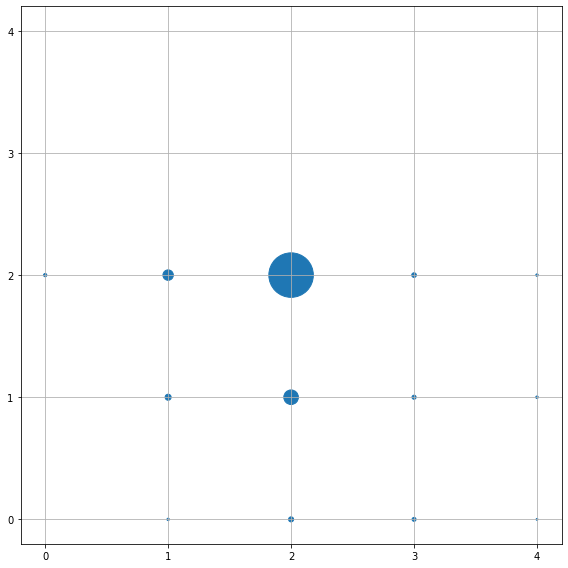

In [49]:
draw_cluster_local(X_test[confident_gam[0]])